# Kanapy – Generation of voxelized RVE
Generate a representation volume element (RVE) for a synthetic microstructure and export geometry as Abaqus INP file. Generate orientation for each grain in form of Euler angles that are characteristic for a given crystallographic texture.


Author: Alexander Hartmaier, ICAMS / Ruhr-University Bochum, Germany<br>
January 2023

### 0. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kanapy as knpy
from math import pi
if int(knpy.__version__[0]) < 6 or int(knpy.__version__[2]) < 1:
    raise ModuleNotFoundError(f'Kanapy version 6.1. or higher is required. Current version is {knpy.__version__}. Please update Kanapy')

### 1. Create geometric representation of microstructure

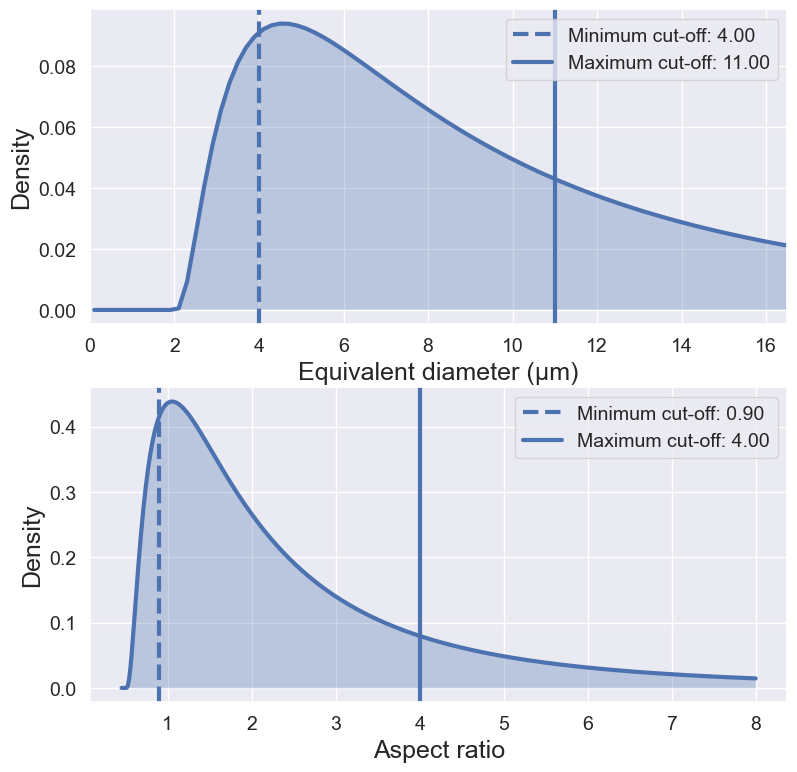

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase Austenite (0)
    Total number of particles  = 29
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (20, 20, 20) (mm)
    Number of voxels (X, Y, Z) = (15, 15, 15)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](mm)
    Total number of voxels     = 3375


Considered phases (volume fraction): 
0: Austenite (100.0%)


Starting particle simulation
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:03<00:00, 216.41it/s]


Completed particle packing
70 overlapping particles detected after packing
Kinetic energy of particles after packing: 3.752533285303804
Initial kinetic energy: 3.752533285303804



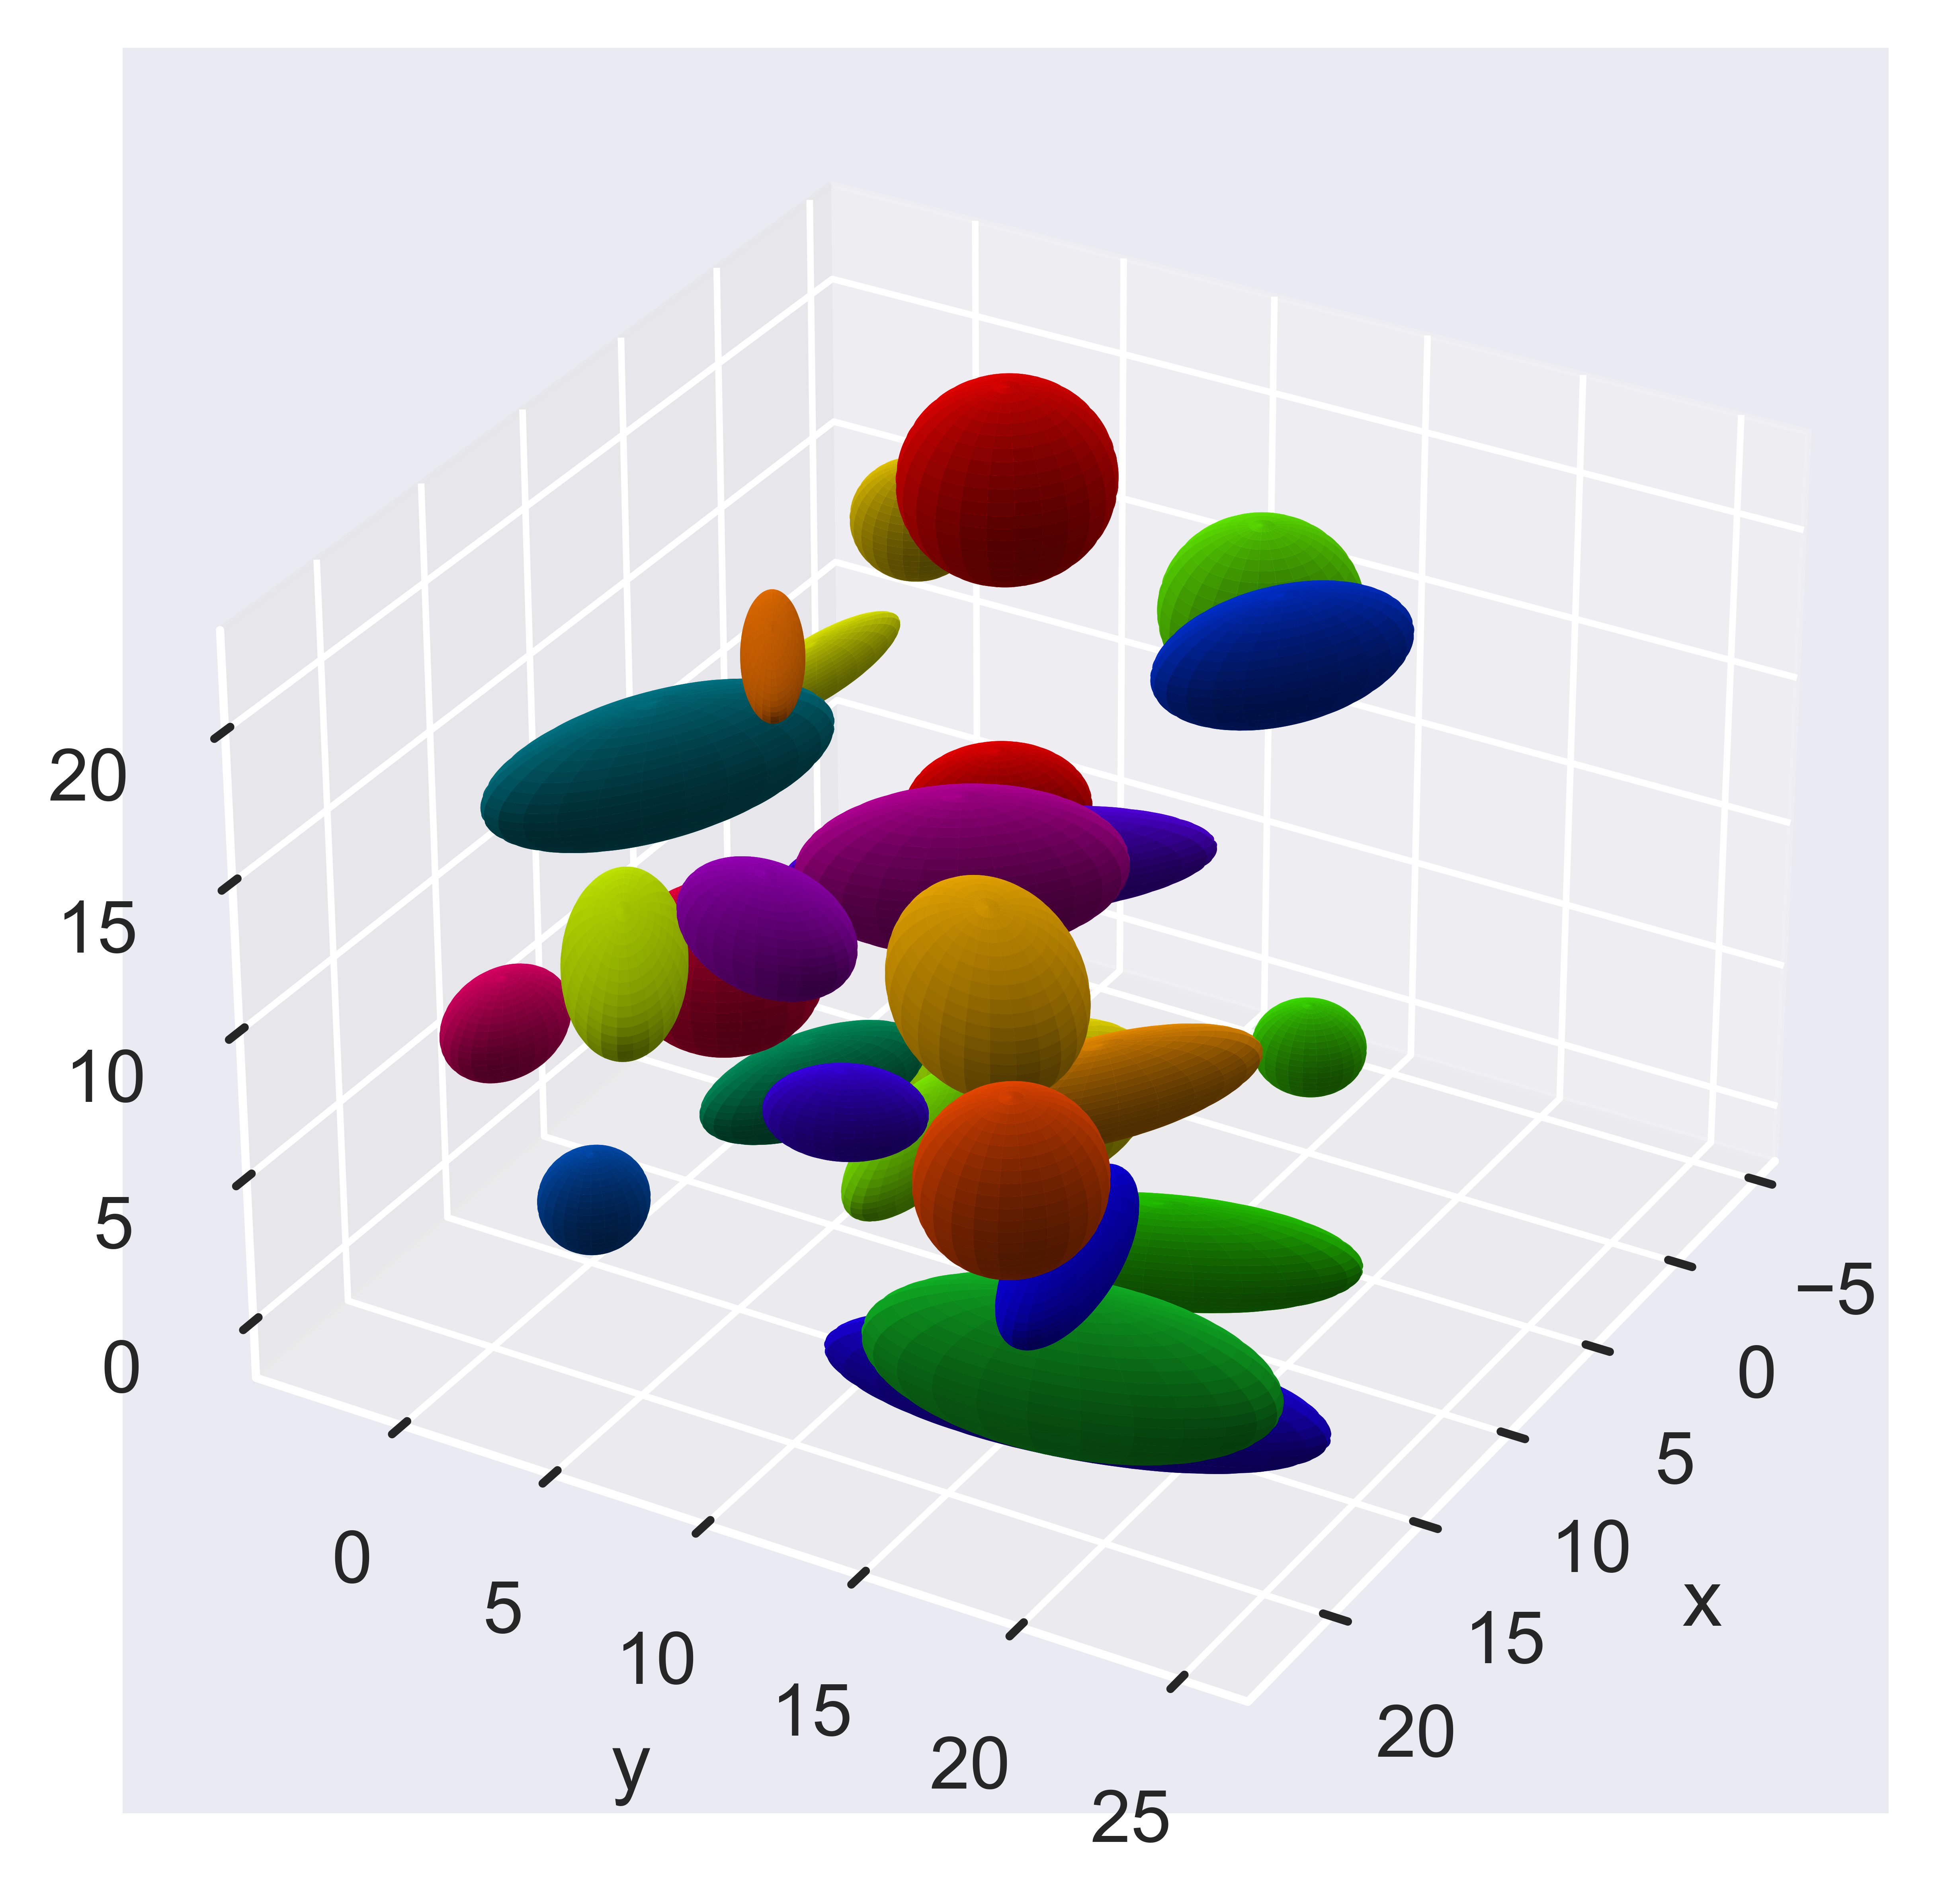

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 4492470.96it/s]


Completed RVE voxelization



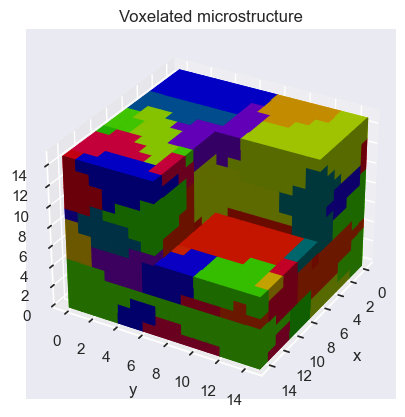


Generated Delaunay tesselation of grain vertices.
Assigning 933 tetrahedra to grains ...


933it [00:02, 351.69it/s]


Finished generating polyhedral hulls for grains.
Total volume of RVE: 8000 mm^3
Total volume of polyhedral grains: 8000.000000000001 mm^3
Mean relative error of polyhedral vs. voxel volume of individual grains: 0.228
for mean volume of grains: 275.862 mm^3.

Computing the L1-error between input and output diameter distributions.
    L1 error phase 0 between particle and grain geometries: 0.55172
Plotting input & output statistics for phase 0


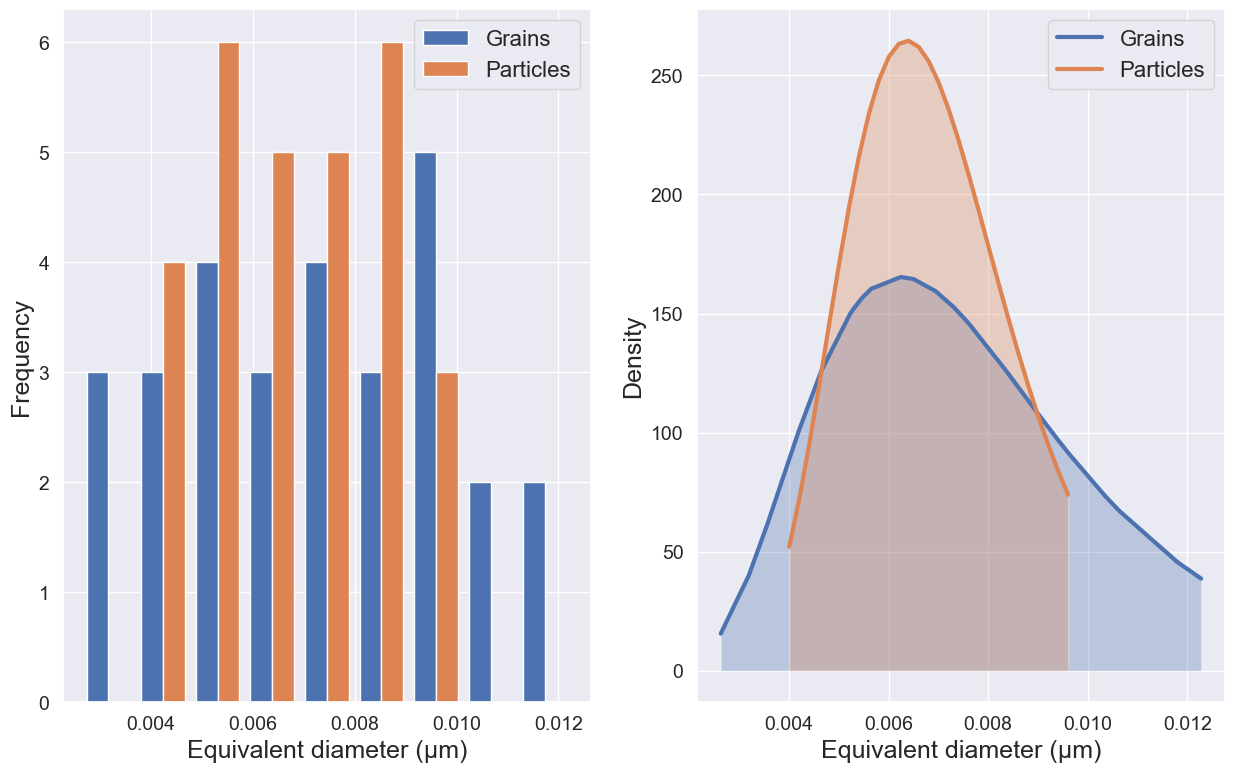

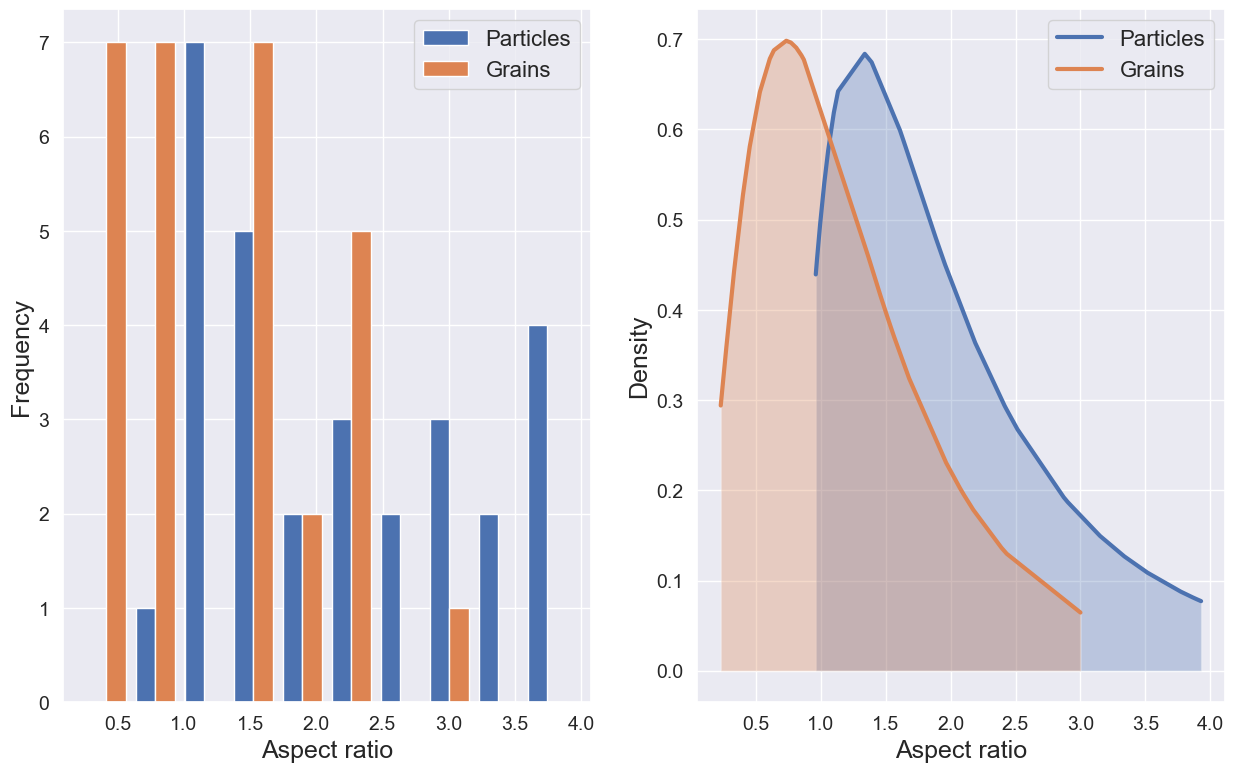

In [2]:
# Basic material definitions
matname = 'Austenite fcc'
matnumber = 4  # UMAT number for fcc Iron
deg = pi/180.0

# RVE and microstructure paramaters
Nv = 15  # number of voxels
size = 20  # size of RVE
periodic = True
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'sig': 1.0, 'scale': 7.0, 'loc': 2.0, 'cutoff_min': 4.0, 'cutoff_max': 11.0},
          'Aspect ratio': {'sig':1.0, 'scale': 1.5, 'loc': 0.5, 'cutoff_min': 0.9, 'cutoff_max': 4.0},
          'Tilt angle': {'kappa': 2.*deg, 'loc': 90.*deg, "cutoff_min": 0.0, "cutoff_max": 180.0*deg},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv, 'ialloy': matnumber},
          'Simulation': {'periodicity': str(periodic), 'output_units': 'mm'},
          'Phase': {'Name': 'Austenite', 'Number': matnumber, 'Volume fraction': 1.0}}

ms = knpy.Microstructure(ms_elong)
ms.plot_stats_init()
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()
ms.voxelize()
ms.plot_voxels()
ms.generate_grains()
ms.plot_stats()

### 1.1 Alternatively load voxel file

JSON files with voxel structures can be imported instead of RVE generation.

In [ ]:
ms = knpy.import_voxels('filename')
ms.generate_grains()
ms.plot_stats()

### 2. Generate set of grain orientations for specified texture

In [3]:
texture = 'goss' # Implemented textures are goss, copper, random
mdf = 'high'
if knpy.MTEX_AVAIL:
    # define standard parameters for misorientation distribution functions
    """Test cases for misorientation distribution (MDF) adapted from
    Miodownik, M., et al. "On boundary misorientation distribution functions
    and how to incorporate them into three-dimensional models of microstructural
    evolution." Acta materialia 47.9 (1999): 2661-2668.
    https://doi.org/10.1016/S1359-6454(99)00137-8
    """
    mdf_freq = {
      "high": [0.0013303016, 0.208758929, 0.3783092708, 0.7575794912, 1.6903069613,
               2.5798481069, 5.0380640643, 10.4289690569, 21.892113657, 21.0,
               22.1246762077, 13.9000439533],
      "low":  [4.5317, 18.6383, 25, 20.755, 12.5984, 7.2646, 4.2648, 3.0372, 2.5,
               1, 0.31, 0.1],
      "random": [0.1, 0.67, 1.9, 3.65, 5.8, 8.8, 11.5, 15.5, 20, 16.7, 11.18, 4.2]
    }
    mdf_bins = np.linspace(62.8/12,62.8,12)

    # generate grain orientations and write ang file
    """
    Different textures can be choosen and assinged to the RVE geometry that has
    been defined above.
    Texture is defined by the orientation of the ideal component in Euler space
    ang and a kernel halfwidth omega. Kernel used here is deLaValleePoussin.
    The function createOriset will first create an artificial EBSD by sampling
    a large number of discrete orientations from the ODF defined by ang and
    omega. Then a reduction method is applied to reconstruct this initial ODF
    with a smaller number of discrete orientations Ngr. The reduced set of
    orientations is returned by the function.
    For more information on the method see:
    https://doi.org/10.1107/S1600576719017138
    """
    if texture == 'goss':
        ang = [0, 45, 0]    # Euler angle for Goss texture
        omega = 7.5         # kernel half-width
        tdesc = 'unimodal'
    elif texture == 'copper':
        ang = [90, 35, 45]
        omega = 7.5
        tdesc = 'unimodal'
    elif texture == 'random':
        ang = None
        omega = None
        tdesc = 'random'
    else:
        raise ValueError('texture not defined. Take goss, copper or random')
    ms.generate_orientations(tdesc, ang=ang, omega=omega, 
                             hist=mdf_freq[mdf], Nbase=1000)


I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  ....Warning: "/Volumes/Extern/Codes/kanapy/libs/mtex/extern/nfft_openMP" not found in path.
> In rmpath>doRemoveFromPath (line 102)
In rmpath (line 59)
In check_installation (line 7)
In startup_mtex (line 79)
In startup (line 9)

********************************************************************************

********************************************************************************
 done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 

time =

   10.4583


e =

   49.8945


e =

   49.8886


e =

   49.8611


e =

   49.8405


e =

   49.8383


e =

   49.8014


e =

   49.7530


e =

   49.7321


e =

   49.7265


e =

   49.7256


e =

   49.7101


e =

   49.6926


e =

   49.6823


e =

   49.6160


e =

   49.6158


e =

   49.6031


e =

   49.5876


e =

   49.56

### 3. Write Abaquis input deck

In [4]:
# write Abaqus input file for voxelated geometry (_geom.inp) and Euler angles (_mat.inp)
ptag = 'pbc' if periodic else 'no_pbc'
fname = ms.write_abq(nodes='v', file=f'abq{Nv}_gr{ms.Ngr}_{ptag}_geom.inp')


Writing RVE as ABAQUS file "./abq15_gr29_pbc_geom.inp"
Using brick element type C3D8.
---->DONE!

